In [1]:
"""
Author: ShengChih Lin
Student Number: 45427804
Course: Comp3701 
Task: Segment the OASIS brain data set with an Improved UNet with all labels having 
a minimum Dice similarity coefficient of 0.9 on the test set.
"""


import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Add, Activation, concatenate, Conv2D, Dropout, LeakyReLU, Input, UpSampling2D
from tensorflow.keras.models import Model
from keras.layers import LeakyReLU
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import glob
import os
from PIL import Image
from tensorflow.keras.utils import to_categorical

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [2]:
#connect to the google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
#unzip files on google drive
!unzip '/gdrive/My Drive/keras_png_slices_data.zip' -d '/gdrive/My Drive/comp3710project'

Streaming output truncated to the last 5000 lines.
  inflating: /gdrive/My Drive/comp3710project/__MACOSX/keras_png_slices_data/keras_png_slices_seg_train/._seg_332_slice_2.nii.png  
  inflating: /gdrive/My Drive/comp3710project/keras_png_slices_data/keras_png_slices_seg_train/seg_382_slice_26.nii.png  
  inflating: /gdrive/My Drive/comp3710project/__MACOSX/keras_png_slices_data/keras_png_slices_seg_train/._seg_382_slice_26.nii.png  
  inflating: /gdrive/My Drive/comp3710project/keras_png_slices_data/keras_png_slices_seg_train/seg_068_slice_7.nii.png  
  inflating: /gdrive/My Drive/comp3710project/__MACOSX/keras_png_slices_data/keras_png_slices_seg_train/._seg_068_slice_7.nii.png  
  inflating: /gdrive/My Drive/comp3710project/keras_png_slices_data/keras_png_slices_seg_train/seg_261_slice_21.nii.png  
  inflating: /gdrive/My Drive/comp3710project/__MACOSX/keras_png_slices_data/keras_png_slices_seg_train/._seg_261_slice_21.nii.png  
  inflating: /gdrive/My Drive/comp3710project/keras_pn

In [ ]:
import os
path = "/gdrive/My Drive"
os.chdir(path)
os.listdir(path)

['Colab Notebooks',
 'keras_png_slices_data.zip',
 'data',
 'AKOA_Analysis.zip',
 'comparisons.png',
 'ImageName',
 'ISIC2018_Task1-2_Training_Data.zip',
 'demo2_part3_u-net.ipynb',
 'comp3710project']

In [5]:
#load data
file_train_y = glob.glob('/gdrive/My Drive/comp3710project/keras_png_slices_data/keras_png_slices_seg_train/*.png')
file_train_y = sorted(file_train_y)

In [6]:
y_train = np.array([np.array(Image.open(fname)) for fname in file_train_y])
print(y_train.shape)

(9664, 256, 256)


In [7]:
file_test_y = glob.glob('/gdrive/My Drive/comp3710project/keras_png_slices_data/keras_png_slices_seg_test/*.png')
file_test_y = sorted(file_test_y)
y_test = np.array([np.array(Image.open(fname)) for fname in file_test_y])
print(y_test.shape)

(544, 256, 256)


In [8]:


file_train_x = glob.glob('/gdrive/My Drive/comp3710project/keras_png_slices_data/keras_png_slices_train/*.png')
file_train_x = sorted(file_train_x)
x_train = np.array([np.array(Image.open(fname)) for fname in file_train_x])
print(x_train.shape)

(9664, 256, 256)


In [9]:
file_test_x = glob.glob('/gdrive/My Drive/comp3710project/keras_png_slices_data/keras_png_slices_test/*.png')
file_test_x = sorted(file_test_x)
x_test = np.array([np.array(Image.open(fname)) for fname in file_test_x])
print(x_test.shape)

(544, 256, 256)


In [10]:
X_train4D = x_train.reshape(x_train.shape[0],256,256,1)#.astype('float32')
X_test4D = x_test.reshape(x_test.shape[0],256,256,1)#.astype('float32')
X_train4D.shape

(9664, 256, 256, 1)

In [11]:
#normalization
X_train4D_norm = X_train4D/255
X_test4D_norm = X_test4D/255

In [12]:

y_train_labels =  y_train/85
y_test_labels = y_test/85

In [13]:
#if use float32, the RAM will run out
y_train_labels = to_categorical(y = y_train_labels,
                            num_classes = 4,
                            dtype='uint8')#integer type

In [14]:
y_test_labels = to_categorical(y=y_test_labels,
                            num_classes = 4,
                            dtype='uint8')#integer type

In [15]:

#change back to float32
y_train_labels = y_train_labels.astype(np.float32)
y_train_labels.dtype

dtype('float32')

In [16]:
y_test_labels = y_test_labels.astype(np.float32)
y_test_labels.dtype

dtype('float32')

In [ ]:
# Improved Unet
inputs = Input(shape=(256, 256, 1))

Conv = Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(inputs)

'''
context module: it is a pre-activation residual block with two 3X3X3 convolutional layers and a dropout layer (drop = 0.3) 
in between, and it is followed by 3x3x3 convolutions with input stride 2. The purpose is to allow more features while downing 
to the aggregation pathway and to reduce the resolution of the feature maps. There are 5 context modules in the model which 
are cont1, cont2, cont3, cont4 and cont5
'''

Cont1 = Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(Conv)
D1 = Dropout(0.3)(Cont1)
Cont1 = Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(D1)
Cont1 = Add()([Conv, Cont1])# using Add combine previous convolution

# context module is followed by 3x3x3 convolutions with input stride 2.
down1 = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same', strides=(2, 2))(Cont1)

Cont2 = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(down1)
D2 = Dropout(0.3)(Cont2)
Cont2 = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(D2)   
Cont2 = Add()([down1, Cont2])

down2 = Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same', strides=(2, 2))(Cont2)
    
Cont3 = Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(down2)
D3 = Dropout(0.3)(Cont3)
Cont3 = Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(D3)
Cont3 = Add()([down2, Cont3])

down3 = Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same', strides=(2, 2))(Cont3)
    
Cont4 = Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(down3)
D4 = Dropout(0.3)(Cont4)
Cont4 = Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(D4)   
Cont4 = Add()([down3, Cont4])

down4 = Conv2D(256, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same', strides=(2, 2))(Cont4)

Cont5 = Conv2D(256, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(down4)
D5 = Dropout(0.3)(Cont5)
Cont5 = Conv2D(256, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(D5)
Cont5 = Add()([down4, Cont5])

'''Upsampling modul: it is to upsampling the low-resolution feature maps and connected by a 3x3x3 convolution that halves the number of feature
maps. There are 4 upsampling modul which are up1, up2,up3, up4'''

up1 = UpSampling2D()(Cont5)
up1 = Conv2D(128, (3, 3), padding='same')(up1)

# concatenate() is to connect upsampling layer and context module
Conca1 = concatenate([up1, Cont4])

'''locolization module: it contains a 3x3x3 convolution and a 1x1x1 convolution which reduces half of number of feature maps.'''
Local1 = Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(Conca1)
Local1 = Conv2D(128, (1, 1), activation=LeakyReLU(alpha=0.01), padding='same')(Local1)

up2 = UpSampling2D()(Local1)
up2 = Conv2D(64, (3, 3), padding='same')(up2)

Conca2 = concatenate([up2, Cont3])

Local2 = Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(Conca2)
Local2 = Conv2D(64, (1, 1), activation=LeakyReLU(alpha=0.01), padding='same')(Local2)

up3 = UpSampling2D()(Local2)
up3 = Conv2D(32, (3, 3), padding='same')(up3)

Conca3 = concatenate([up3, Cont2])

Local3 = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(Conca3)
Local3 = Conv2D(32, (1, 1), activation=LeakyReLU(alpha=0.01), padding='same')(up3)


up4 = UpSampling2D()(Local3)
up4 = Conv2D(16, (3, 3), padding='same')(up4)

Conca4 = concatenate([up4, Cont1])

M10 = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(Conca4)

#add all segmentation layers
Seg1 = Conv2D(4, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(Local2)
Seg1 = UpSampling2D()(Seg1)
Seg2 = Conv2D(4, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(up3)
Seg3 = Conv2D(4, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(M10)

seg12 = Add()([Seg1, Seg2])
seg12 = UpSampling2D()(seg12)
seg123 = Add()([seg12, Seg3])

final = Conv2D(4, (1, 1), activation="softmax")(seg123)
model = Model(inputs=inputs, outputs=final)

In [ ]:
#set learning rates
opt = keras.optimizers.Adam(learning_rate=1e-4)

In [ ]:
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train4D_norm, y_train_labels, epochs=15, batch_size=8, validation_split=0.2, verbose=2)

Epoch 1/15
967/967 - 44s - loss: 0.2033 - accuracy: 0.9199 - val_loss: 0.1242 - val_accuracy: 0.9471
Epoch 2/15
967/967 - 43s - loss: 0.0865 - accuracy: 0.9653 - val_loss: 0.0869 - val_accuracy: 0.9628
Epoch 3/15
967/967 - 43s - loss: 0.0650 - accuracy: 0.9737 - val_loss: 0.0558 - val_accuracy: 0.9774
Epoch 4/15
967/967 - 43s - loss: 0.0559 - accuracy: 0.9773 - val_loss: 0.0516 - val_accuracy: 0.9795
Epoch 5/15
967/967 - 43s - loss: 0.0510 - accuracy: 0.9792 - val_loss: 0.0517 - val_accuracy: 0.9786
Epoch 6/15
967/967 - 43s - loss: 0.0474 - accuracy: 0.9807 - val_loss: 0.0423 - val_accuracy: 0.9832
Epoch 7/15
967/967 - 43s - loss: 0.0446 - accuracy: 0.9817 - val_loss: 0.0410 - val_accuracy: 0.9838
Epoch 8/15
967/967 - 43s - loss: 0.0422 - accuracy: 0.9827 - val_loss: 0.0391 - val_accuracy: 0.9844
Epoch 9/15
967/967 - 43s - loss: 0.0404 - accuracy: 0.9834 - val_loss: 0.0409 - val_accuracy: 0.9833
Epoch 10/15
967/967 - 43s - loss: 0.0392 - accuracy: 0.9839 - val_loss: 0.0378 - val_accura

In [ ]:
prediction=model.predict(X_test4D_norm)

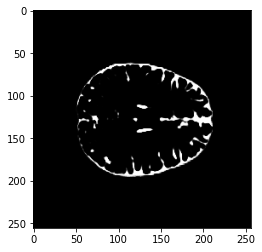

In [ ]:
#prediction
plt.imshow(prediction[470][:,:,1], cmap=plt.cm.gray)

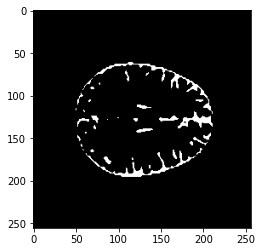

In [ ]:

plt.imshow(y_test_labels[470][:,:,1], cmap=plt.cm.gray)

In [17]:
'''The Dice coefficient is a ensemble similarity measurement function, usually used to 
calculate the similarity of two samples, with a value range of [0,1]:'''
def dice_coeff(y_true, y_pred):
    
    intersection = tf.math.reduce_sum(y_true * y_pred, axis=[1,2])
    union = tf.math.reduce_sum(y_true, axis=[1,2]) + tf.math.reduce_sum(y_pred, axis=[1,2])
    mean_loss = (2. * intersection) / (union + 1e-6)
    return tf.reduce_mean(mean_loss, axis=0)
    
def dice_coeff_loss(y_true, y_pred):
  return 1- tf.reduce_mean(dice_coeff(y_true, y_pred))

In [ ]:
#dice_codfficient testing
dice_coeff(y_test_labels, prediction)

In [ ]:
dice_coeff_loss(y_test_labels,prediction)

In [18]:
'''context module: it is a pre-activation residual block with two 3X3X3 convolutional layers and a dropout layer (drop = 0.3) in between, and it is followed by 3x3x3 convolutions with input stride 2. The purpose is to allow more features while downing to the aggregation pathway and to reduce the
resolution of the feature maps. There are 5 context modules in the model which are cont1, cont2, cont3, cont4 and cont5'''
inputs = Input(shape=(256, 256, 1))

Conv = Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(inputs)

Cont1 = Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(Conv)
D1 = Dropout(0.3)(Cont1)
Cont1 = Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(D1)

Cont1 = Add()([Conv, Cont1])


down1 = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same', strides=(2, 2))(Cont1)

Cont2 = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(down1)
D2 = Dropout(0.3)(Cont2)
Cont2 = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(D2)   
Cont2 = Add()([down1, Cont2])

down2 = Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same', strides=(2, 2))(Cont2)
    
Cont3 = Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(down2)
D3 = Dropout(0.3)(Cont3)
Cont3 = Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(D3)
Cont3 = Add()([down2, Cont3])

down3 = Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same', strides=(2, 2))(Cont3)
    
Cont4 = Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(down3)
D4 = Dropout(0.3)(Cont4)
Cont4 = Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(D4)   
Cont4 = Add()([down3, Cont4])

down4 = Conv2D(256, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same', strides=(2, 2))(Cont4)

Cont5 = Conv2D(256, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(down4)
D5 = Dropout(0.3)(Cont5)
Cont5 = Conv2D(256, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(D5)
Cont5 = Add()([down4, Cont5])

up1 = UpSampling2D()(Cont5)
up1 = Conv2D(128, (3, 3), padding='same')(up1)

Conca1 = concatenate([up1, Cont4])

Local1 = Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(Conca1)
Local1 = Conv2D(128, (1, 1), activation=LeakyReLU(alpha=0.01), padding='same')(Local1)

up2 = UpSampling2D()(Local1)
up2 = Conv2D(64, (3, 3), padding='same')(up2)

Conca2 = concatenate([up2, Cont3])

Local2 = Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(Conca2)
Local2 = Conv2D(64, (1, 1), activation=LeakyReLU(alpha=0.01), padding='same')(Local2)

up3 = UpSampling2D()(Local2)
up3 = Conv2D(32, (3, 3), padding='same')(up3)

Conca3 = concatenate([up3, Cont2])

Local3 = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(Conca3)
Local3 = Conv2D(32, (1, 1), activation=LeakyReLU(alpha=0.01), padding='same')(up3)


up4 = UpSampling2D()(Local3)
up4 = Conv2D(16, (3, 3), padding='same')(up4)

Conca4 = concatenate([up4, Cont1])

M10 = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(Conca4)

#add all segmentation layers
Seg1 = Conv2D(4, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(Local2)
Seg1 = UpSampling2D()(Seg1)
Seg2 = Conv2D(4, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(up3)
Seg3 = Conv2D(4, (3, 3), activation=LeakyReLU(alpha=0.01), padding='same')(M10)

seg12 = Add()([Seg1, Seg2])
seg12 = UpSampling2D()(seg12)
seg123 = Add()([seg12, Seg3])

final = Conv2D(4, (1, 1), activation="softmax")(seg123)
model_dice = Model(inputs=inputs, outputs=final)

In [19]:
opt = keras.optimizers.Adam(learning_rate=1e-4)

In [20]:
model_dice.compile(optimizer = opt, loss = dice_coeff_loss, metrics = [dice_coeff])

In [21]:
checkpoint_path = "training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [22]:
EPOCHS = 80
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [23]:
history2 = model_dice.fit(X_train4D_norm, y_train_labels, epochs=EPOCHS, callbacks=[model_checkpoint_callback],
                          batch_size=8, validation_split=0.2, verbose=2)

Epoch 1/80
967/967 - 43s - loss: 0.2131 - dice_coeff: 0.7870 - val_loss: 0.1183 - val_dice_coeff: 0.8817
Epoch 2/80
967/967 - 42s - loss: 0.1011 - dice_coeff: 0.8989 - val_loss: 0.0918 - val_dice_coeff: 0.9082
Epoch 3/80
967/967 - 42s - loss: 0.0829 - dice_coeff: 0.9171 - val_loss: 0.0720 - val_dice_coeff: 0.9280
Epoch 4/80
967/967 - 42s - loss: 0.0723 - dice_coeff: 0.9277 - val_loss: 0.0774 - val_dice_coeff: 0.9225
Epoch 5/80
967/967 - 42s - loss: 0.0652 - dice_coeff: 0.9348 - val_loss: 0.0599 - val_dice_coeff: 0.9400
Epoch 6/80
967/967 - 42s - loss: 0.0598 - dice_coeff: 0.9402 - val_loss: 0.0709 - val_dice_coeff: 0.9290
Epoch 7/80
967/967 - 42s - loss: 0.0565 - dice_coeff: 0.9435 - val_loss: 0.0757 - val_dice_coeff: 0.9242
Epoch 8/80
967/967 - 42s - loss: 0.0532 - dice_coeff: 0.9468 - val_loss: 0.0559 - val_dice_coeff: 0.9440
Epoch 9/80
967/967 - 42s - loss: 0.0506 - dice_coeff: 0.9494 - val_loss: 0.0682 - val_dice_coeff: 0.9317
Epoch 10/80
967/967 - 42s - loss: 0.0483 - dice_coeff: 

In [24]:
!ls {checkpoint_dir}

checkpoint  cp.ckpt.data-00000-of-00001  cp.ckpt.index


In [25]:
model_dice.evaluate(X_test4D_norm,  y_test_labels, verbose=2)
#model_dice.load_weights(checkpoint_path)

17/17 - 1s - loss: 0.0319 - dice_coeff: 0.9681


[0.03193572163581848, 0.9680642485618591]

In [26]:
pre_dice=model_dice.predict(X_test4D_norm)

In [27]:
dice_coeff(y_test_labels,pre_dice)

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9987185 , 0.94281095, 0.95675904, 0.9739685 ], dtype=float32)>

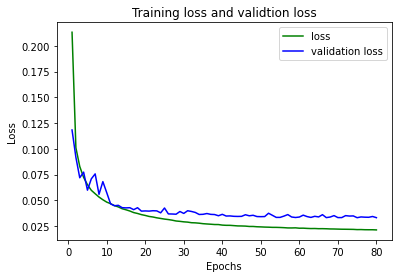

In [29]:
#plot the traing loss and validation loss
loss_train = history2.history['loss']
loss_val = history2.history['val_loss']
epochs = range(1,81)
plt.plot(epochs, loss_train, 'g', label='loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training loss and validtion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

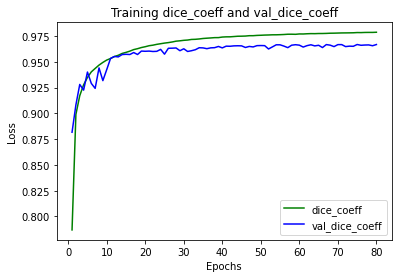

In [31]:
#plot dice_coefficient 
loss_train = history2.history['dice_coeff']
loss_val = history2.history['val_dice_coeff']
epochs = range(1,81)
plt.plot(epochs, loss_train, 'g', label='dice_coeff')
plt.plot(epochs, loss_val, 'b', label='val_dice_coeff')
plt.title('Training dice_coeff and val_dice_coeff')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()